In [1]:
import webbpsf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
%matplotlib inline
import pylab as pl

In [3]:
nrc = webbpsf.NIRCam()
#nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F405N'
grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
nrc.detector = 'NRCA5'
grida = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True)
nrc.detector = 'NRCB5'
gridb = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True)


Running instrument: NIRCam, filter: F405N
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.4203630562211, 201.72320035368165)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.523023735497, 201.6277413650047)
    Position 3/16: (0, 1365) pixels
    Position 3/16 centroid: (201.53197410885423, 201.5517164523594)
    Position 4/16: (0, 2047) pixels
    Position 4/16 centroid: (201.61835281634504, 201.55659361917634)
    Position 5/16: (682, 0) pixels
    Position 5/16 centroid: (201.4450357295695, 201.6211853968086)
    Position 6/16: (682, 682) pixels
    Position 6/16 centroid: (201.46754550370102, 201.6316619718074)
    Position 7/16: (682, 1365) pixels
    Position 7/16 centroid: (201.46166434722093, 201.58088020943816)
    Position 8/16: (682, 2047) pixels
    Position 8/16 centroid: (201.53416437469664, 201.51308620613744)
    Position 9/16: (1365, 0) pixels
    Position 9/16 centroid: (201.5163457395047, 201.52656132205

In [4]:
grid

[<photutils.psf.griddedpsfmodel.GriddedPSFModel>
 Detector: ('NRCA5', 'Detector name')
 Filter: ('F405N', 'Filter name')
 Grid_shape: (4, 4)
 Number of ePSFs: 16
 ePSF shape (oversampled pixels): (404, 404)
 Oversampling: 4,
 <photutils.psf.griddedpsfmodel.GriddedPSFModel>
 Detector: ('NRCB5', 'Detector name')
 Filter: ('F405N', 'Filter name')
 Grid_shape: (4, 4)
 Number of ePSFs: 16
 ePSF shape (oversampled pixels): (404, 404)
 Oversampling: 4]

In [5]:
nrc.detector, nrc.detector_list, nrc.detector_position

('NRCB5',
 ['NRCA1',
  'NRCA2',
  'NRCA3',
  'NRCA4',
  'NRCA5',
  'NRCB1',
  'NRCB2',
  'NRCB3',
  'NRCB4',
  'NRCB5'],
 (2047, 2047))

In [6]:
g0=grid[0]

In [7]:
g0.meta['detector']

('NRCA5', 'Detector name')

In [8]:
grids = {g.meta['detector'][0]: g for g in grid}

In [9]:
import stdatamodels.jwst.datamodels
from astropy.io import fits
from astropy.wcs import WCS
import glob

In [10]:
files = {'nrca': '/orange/adamginsburg/jwst/brick/F405N/pipeline/*nrca*_cal.fits',
         'nrcb': '/orange/adamginsburg/jwst/brick/F405N/pipeline/*nrcb*_cal.fits',
        }
#parent_file = stdatamodels.jwst.datamodels.open
parent_file = fits.open('/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')
parent_wcs = WCS(parent_file[1].header)

Set DATE-AVG to '2022-08-28T00:59:05.370' from MJD-AVG.
Set DATE-END to '2022-08-28T01:27:10.957' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.725189 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527161940.784 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [11]:
parent_file[1].data.shape

(2334, 5690)

In [12]:
parent_wcs.pixel_to_world(0, 0)
parent_wcs.pixel_to_world(parent_file[1].data.shape[0], parent_file[1].data.shape[1])

<SkyCoord (ICRS): (ra, dec) in deg
    (266.625859, -28.72034947)>

In [13]:
import numpy as np
from astropy.visualization import simple_norm
from tqdm.auto import tqdm

In [14]:
grids.keys()

dict_keys(['NRCA5', 'NRCB5'])

In [15]:
def footprint_contains(x, y, shape):
    return (x > 0) and (y > 0) and (y < shape[0]) and (x < shape[1])

  0%|          | 0/32 [00:00<?, ?it/s]

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/asdf/entry_points.py:48: AsdfWarning: asdf_extensions plugin from package specutils==1.9.1 failed to load:

ModuleNotFoundError: No module named 'astropy.io.misc.asdf.extension'
  warnings.warn(


4


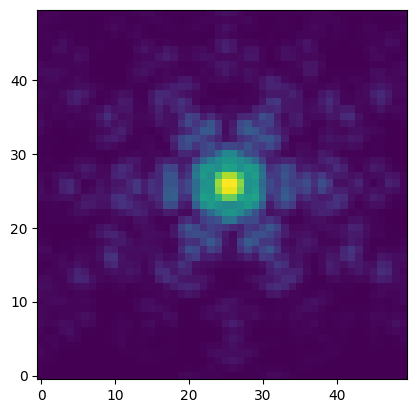

In [16]:
pixc1 = [100, 100]
skyc1 = parent_wcs.pixel_to_world(*pixc1)

psfs = []
for fn in tqdm(glob.glob('/orange/adamginsburg/jwst/brick/F466N/pipeline/*nrca*_cal.fits')):
    dmod = stdatamodels.jwst.datamodels.open(fn)
    xc, yc = dmod.meta.wcs.world_to_pixel(skyc1)
    if footprint_contains(xc, yc, dmod.data.shape):
        yy, xx = np.mgrid[int(yc)-25:int(yc)+25, int(xc)-25:int(xc)+25]
        psf = grids['NRCA5'].evaluate(x=xx, y=yy, flux=1, x_0=xc, y_0=yc)
        psfs.append(psf)
print(len(psfs))
pl.imshow(psf, origin='lower', norm=simple_norm(psf, stretch='log'))

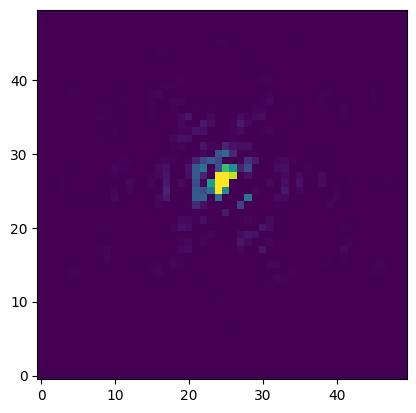

In [17]:
pl.imshow(np.array(psfs).mean(axis=0) - psfs[0], origin='lower', norm=simple_norm(psf, min_percent=1, max_percent=99, stretch='asinh'))

### Above is development, let's try for real

In [18]:
from photutils.psf import GriddedPSFModel
from astropy.nddata import NDData

In [19]:
gridfh = fits.open('nircam_nrca5_f405n_fovp101_samp4_npsf16.fits')
ndd = NDData(gridfh[0].data, meta=dict(gridfh[0].header))
ndd.meta['grid_xypos'] = [((float(ndd.meta[key].split(',')[1].split(')')[0])),
                                  (float(ndd.meta[key].split(',')[0].split('(')[1])))
                                  for key in ndd.meta.keys() if "DET_YX" in key]

ndd.meta['oversampling'] = ndd.meta["OVERSAMP"]  # just pull the value
ndd.meta = {key.lower(): ndd.meta[key] for key in ndd.meta}

model = GriddedPSFModel(ndd)
model

<photutils.psf.griddedpsfmodel.GriddedPSFModel>
Detector: NRCA5
Filter: F405N
Grid_shape: (4, 4)
Number of ePSFs: 16
ePSF shape (oversampled pixels): (404, 404)
Oversampling: 4

In [20]:
from webbpsf.utils import to_griddedpsfmodel

In [21]:
import copy

# epsf

In [22]:
import numpy as np
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
from photutils.psf import EPSFBuilder, extract_stars
from photutils.detection import DAOStarFinder, IRAFStarFinder

from astropy.table import Table
from astropy.io import fits
from astropy import stats

In [23]:
filtername = 'f410m'.upper()
module = 'merged-reproject'
desat = ''
basepath = '/orange/adamginsburg/jwst/brick/'

print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])

pupil = 'clear'
filename = f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}_i2d{desat}.fits'
fh = fits.open(filename)


im1 = fh
data = im1[1].data
err = im1['ERR'].data


filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)


daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40)
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data))
print(len(finstars))

Starting filter F410M


2024-06-18 07:39:06,696 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Error estimate for DAO from stats.: (11.711935504126746, 10.929444557765745, 6.457339070099435)
Error estimate for DAO from median(err): 0.15527464179765613
Finding stars with daofind_tuned
262729


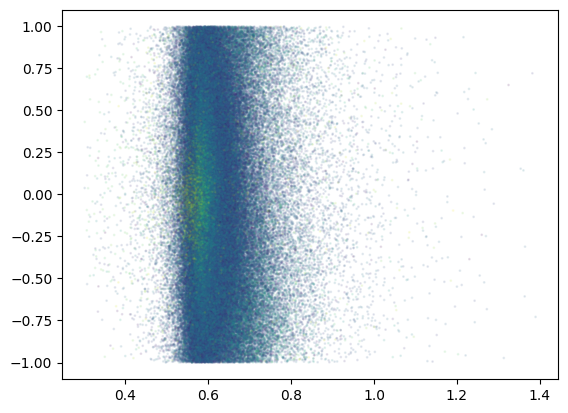

In [24]:
pl.scatter(finstars['sharpness'], finstars['roundness1'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

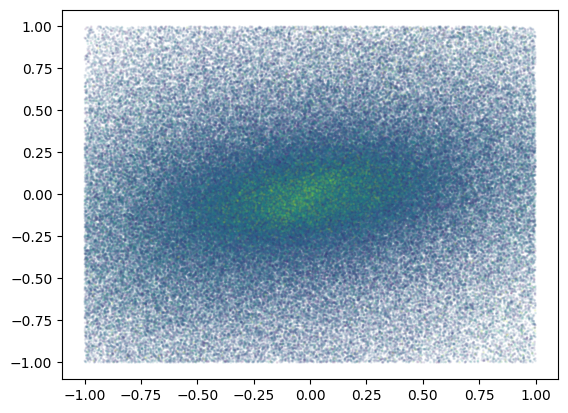

In [25]:
pl.scatter(finstars['roundness1'], finstars['roundness2'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

In [26]:
from astropy.nddata import NDData
from astropy.visualization import simple_norm
import pylab as pl

In [27]:
daofind_tuned = DAOStarFinder(threshold=15 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=0.25, roundlo=-0.25,
                              sharplo=0.40, sharphi=0.8)
finstars = daofind_tuned(np.nan_to_num(data))
finstars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2258.305755089822,14.36519819080747,0.7999669650914853,-0.0065687406450686105,0.23877887047900023,25,0.0,19.351688960813124,4.632429942206771,-1.6645221501483678
2,2024.7850445845186,14.033348234816126,0.6396453484190844,0.043932154849443364,0.23182767695078701,25,0.0,37.74156436011905,6.928060740282149,-2.1015292165235606
3,2208.8636177734256,16.10006639710991,0.6682390174487305,0.004062620800319557,-0.0358084726093634,25,0.0,19.64432619202812,1.6812580531622356,-0.5640859440138577
4,1867.9723653263222,15.865356534815964,0.4667780160887993,-0.19110573541960757,-0.19938345629649673,25,0.0,46.18734975131053,14.995922764792894,-2.9399329873974835
5,2028.0497532738468,15.779267440219725,0.6213145628555019,0.249410082529042,-0.24888852178689827,25,0.0,28.853965670148902,4.247737463009114,-1.5703941669055819
6,2073.618943844512,16.24241377157807,0.600291213941764,-0.17708694824921828,0.05386162255661131,25,0.0,18.31760807945615,2.5842256359381985,-1.0308260760985968
7,2080.9521149602306,16.46683822853642,0.580858121152116,0.17422879046448278,0.1285071492320826,25,0.0,28.920990168491254,6.1617330995954305,-1.9742572064374853
8,2125.836013331551,15.947178677684441,0.5676266531258581,0.10846836182650947,0.08843597221086702,25,0.0,47.80204972596926,13.305427452129972,-2.8100720783006956
9,2179.2362120139906,15.882450053202124,0.6148164690876032,-0.08947778917817928,-0.005394020096878599,25,0.0,63.67278169904437,18.893786309554116,-3.1907974978444384


Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

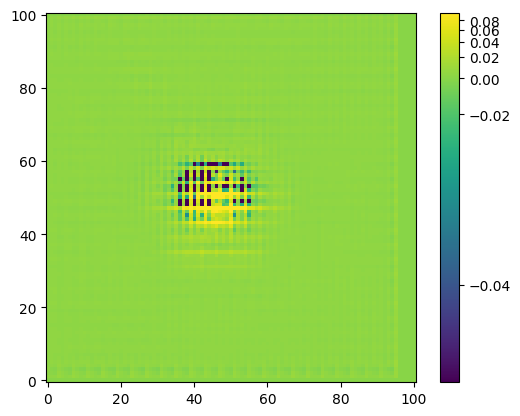

In [28]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

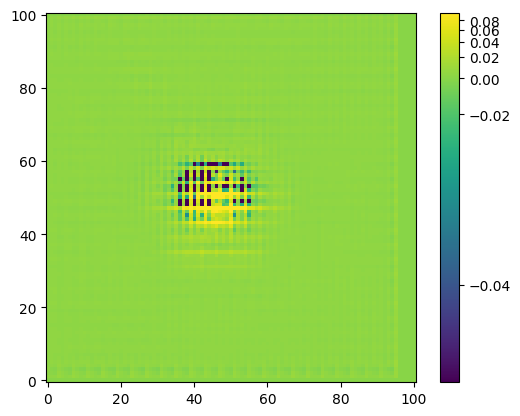

In [29]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

Building EPSF
Using [False False False ... False False  True] stars


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

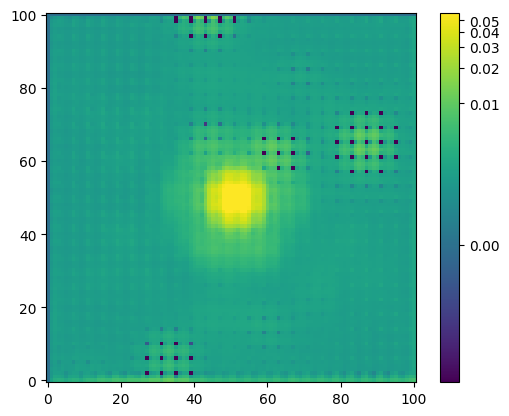

In [30]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

print(f"Using {finstars['peak'] > 100} stars")
stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11766


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

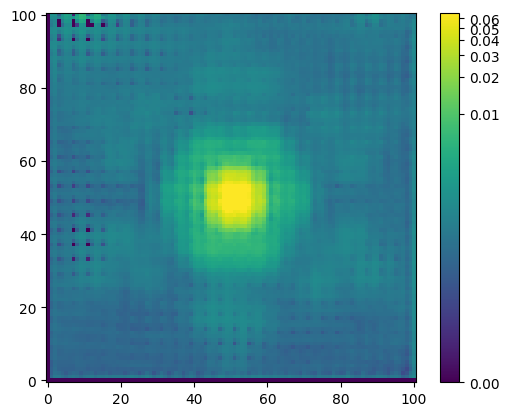

In [31]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

In [32]:
from photutils.psf import EPSFStars

Building EPSF
nstars = 11686


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

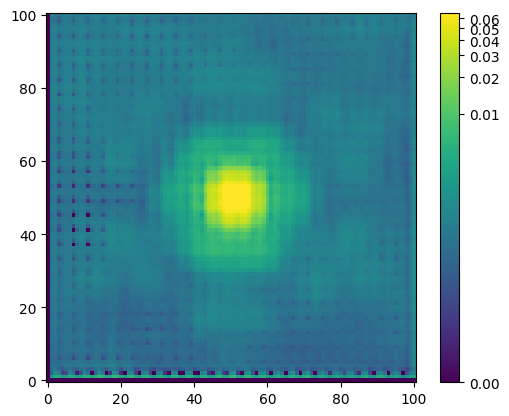

In [33]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 18355


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

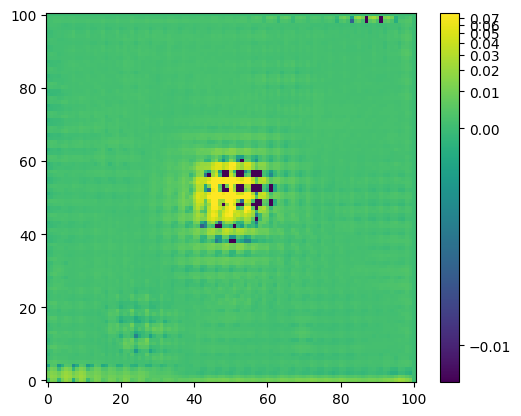

In [34]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 50], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11766


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

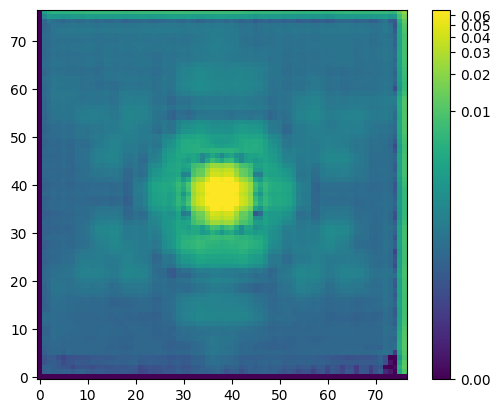

In [35]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

# Best combination

It looks like brighter stars, with peak >200, and oversampling=4 was good enough

Building EPSF
nstars = 8294


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

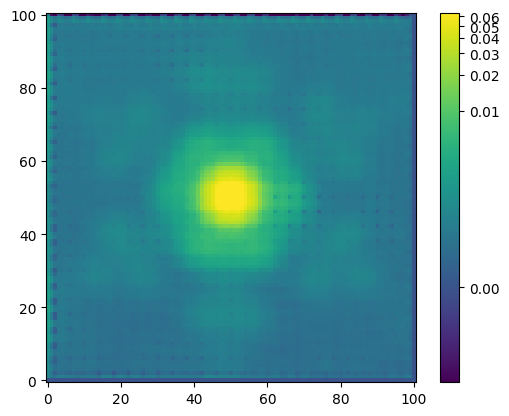

In [36]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
best_epsf = epsf
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

## background subtraction does not do well

Building EPSF
nstars = 11766


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

2024-06-18 10:09:23,332 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fitting region extends beyond the star cutout image.
2024-06-18 10:11:15,345 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fitting region extends beyond the star cutout image.
2024-06-18 10:13:19,411 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fitting region extends beyond the star cutout image.
2024-06-18 10:15:22,790 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fitting region extends beyond the star cutout image.
2024-06-18 10:17:41,267 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fitting region extends beyond the star cutout image.
2024-06-18 10:21:00,928 - stpipe - WARNING - The star at (988.4210075198203, 444.4541422847189) cannot be fit because its fit

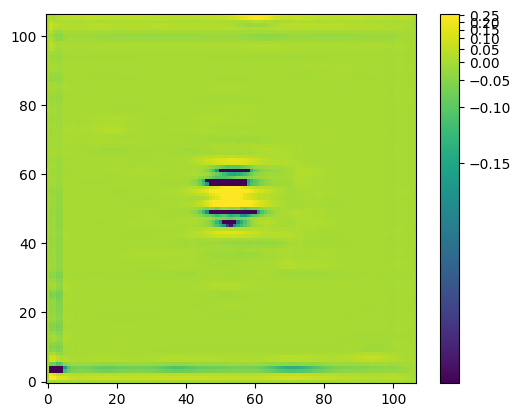

In [37]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

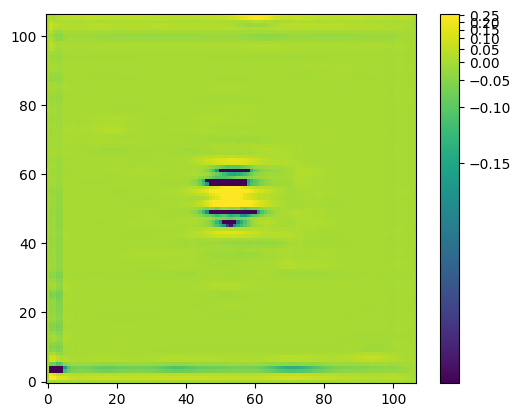

In [38]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

## limiting to brighter stars makes things worse with background

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 8294


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=35)
print(f'nstars = {len(stars)}')

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

# fix psfs

In [ ]:
import sys
sys.path.append('/orange/adamginsburg/jwst/brick/reduction')
import make_merged_psf
import importlib as imp
imp.reload(make_merged_psf)
from make_merged_psf import fix_psfs_with_bad_meta

In [ ]:
import glob
for fn in glob.glob(f"{basepath}/psfs/*.fits"):
    fix_psfs_with_bad_meta(fn)

In [ ]:
filtername = 'f405n'
proposal_id = '2221'
field = '001'
to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample2.fits')

In [ ]:
fix_psfs_with_bad_meta(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample2.fits')

# Verify that WrappedPSFModel works

In [ ]:
sys.path.append('/orange/adamginsburg/jwst/brick/analysis')
import crowdsource_catalogs_long
import importlib as imp
imp.reload(crowdsource_catalogs_long)
from crowdsource_catalogs_long import WrappedPSFModel
from webbpsf.utils import to_griddedpsfmodel

In [ ]:
fh = fits.open(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample2.fits')
fh[0].header['OVERSAMP'], fh[0].header['DET_YX50'], fh[0].data.shape

In [ ]:
fh = fits.open(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample1.fits')
fh[0].header['OVERSAMP'], fh[0].header['DET_YX50'], fh[0].data.shape

In [ ]:
fh = fits.open(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample2.fits')
fh[0].data = fh[0].data[:, 50:-50, 50:-50]
fh[0].data.shape

In [ ]:
grid = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample2.fits')
psf_model = WrappedPSFModel(grid)
proposal_id, field, filtername

In [ ]:
grid = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample1.fits')
psf_model = WrappedPSFModel(grid)
proposal_id, field, filtername

In [ ]:
stampsz=100
rows, cols = np.indices((stampsz, stampsz)) - (np.array([stampsz, stampsz])-1)[:, None, None] / 2.
row, col, i = [1000], [1000], 0
st = grid.evaluate(cols+col[i], rows+row[i], 1, col[i], row[i])
pl.imshow(st, norm=simple_norm(st, stretch='log'))
np.unravel_index(np.argmax(st), st.shape)

In [ ]:
pl.imshow(psf_model(1000,1000), norm=simple_norm(psf_model(1000, 1000), stretch='log'))

## Oversample=1 works, oversample=2 doesn't.  Why?

In [ ]:
grida.evaluate

In [ ]:
stampsz=100
rows, cols = np.indices((stampsz, stampsz)) - (np.array([stampsz, stampsz])-1)[:, None, None] / 2.
row, col, i = [1000], [1000], 0
st = grida.evaluate((cols/2+col[i]), (rows/2+row[i]), 1, col[i], row[i])
pl.imshow(st, norm=simple_norm(st, stretch='log', max_percent=99))
np.unravel_index(np.argmax(st), st.shape)

In [ ]:
halfstampsize = 50
xc, yc = 1000, 1000
oversampling=1
yy, xx = np.mgrid[int(yc)-halfstampsize:int(yc)+halfstampsize, int(xc)-halfstampsize:int(xc)+halfstampsize]
st = grida.evaluate(x=xx/oversampling, y=yy/oversampling, flux=1, x_0=int(xc), y_0=int(yc))
pl.imshow(st, norm=simple_norm(st, stretch='log', max_percent=99))
np.unravel_index(np.argmax(st), st.shape)

In [ ]:
halfstampsize = 50
xc, yc = 1000, 1000
oversampling=2
yy, xx = np.mgrid[int(yc)-halfstampsize:int(yc)+halfstampsize:1/oversampling,
                  int(xc)-halfstampsize:int(xc)+halfstampsize:1/oversampling]
st = grida.evaluate(x=xx, y=yy, flux=1, x_0=int(xc), y_0=int(yc))
pl.imshow(st, norm=simple_norm(st, stretch='log', max_percent=99))
np.unravel_index(np.argmax(st), st.shape)

In [ ]:
yy

## Compare best EPSF to WebbPSF to figure out smoothing kernel (again)

In [ ]:
halfstampsize = 12
xc, yc = 1000, 1000
oversampling=1
yy, xx = np.mgrid[int(yc)-halfstampsize:int(yc)+halfstampsize:1/oversampling,
                  int(xc)-halfstampsize:int(xc)+halfstampsize:1/oversampling]
st = grida.evaluate(x=xx, y=yy, flux=1, x_0=int(xc), y_0=int(yc))
st2 = best_epsf.evaluate(x=xx, y=yy, flux=1, x_0=int(xc), y_0=int(yc))

pl.figure(figsize=(12,4))
pl.subplot(1,3,1)
pl.imshow(st, norm=simple_norm(st, stretch='log', max_percent=99))
pl.subplot(1,3,2)
pl.imshow(st2, norm=simple_norm(st, stretch='log', max_percent=99))
pl.subplot(1,3,3)
pl.imshow(st-st2, norm=simple_norm(st-st2, stretch='linear', min_percent=1, max_percent=99));

In [ ]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel

In [ ]:
sts = convolve(st, Gaussian2DKernel(0.6))
pl.figure(figsize=(12,4))
pl.subplot(1,3,1)
pl.imshow(sts, norm=simple_norm(sts, stretch='log', max_percent=99))
pl.subplot(1,3,2)
pl.imshow(st2, norm=simple_norm(sts, stretch='log', max_percent=99))
pl.subplot(1,3,3)
pl.imshow(sts-st2, norm=simple_norm(sts-st2, stretch='linear', min_percent=1, max_percent=99));

In [ ]:
pl.figure(figsize=(12,4))
for ii,kern in enumerate(np.linspace(0.5, 0.7, 5)):
    sts = convolve(st, Gaussian2DKernel(kern))
    pl.subplot(1,5,ii+1)
    pl.imshow((sts-st2)**2, norm=simple_norm((sts-st2)**2, stretch='asinh', min_percent=1, max_percent=99));
    print(kern, ((sts-st2)**2).sum())